In [1]:
# razor.api.blocks()

# dataset

In [2]:
import os, logging

import cv2
import numpy
from tqdm import tqdm
from razor.api import project_space_path


class MVTecDataset(object):
    def __init__(
            self, is_train, dir_env, is_positive=True, preprocessor=None,
    ):

        ext = dir_env["ext"]
        root = dir_env["root"]
        train_good_dir = dir_env["train_good_dir"]
        test_good_dir = dir_env["test_good_dir"]
        test_bad_dir = dir_env["test_bad_dir"]
        self.preprocessor = preprocessor

        print("£"*20, root)
        logging.info("£"*20, root)
        
        if ext[0] != ".":
            ext = "." + ext

        if is_train:
            dir_name = train_good_dir
        elif not is_positive:
            dir_name = test_good_dir
        elif test_bad_dir:
            dir_name = test_bad_dir
        else:
            dir_name = None
            excp_name = test_good_dir

        if dir_name:
            dir_path = os.path.abspath(os.path.join(root, dir_name))
            print('********', dir_path, dir_name)
            logging.info('********', dir_path, dir_name)
            dir_parent_path = os.path.dirname(dir_path)
            dir_name = os.path.basename(dir_path)
            self.dataset = self.load_dataset(dir_parent_path, dir_name, ext)
        else:
            dir_path = os.path.abspath(os.path.join(root, excp_name))
            dir_parent_path = os.path.dirname(dir_path)
            dirs = [
                d
                for d in os.listdir(dir_parent_path)
                if d not in excp_name
            ]
            self.dataset = []
            for dir_name in dirs:
                self.dataset.extend(self.load_dataset(
                    dir_parent_path, dir_name, ext))

    def load_dataset(self, dir_parent_path, dir_name, ext):

        return [
            (dir_name, f, cv2.imread(os.path.join(
                dir_parent_path, dir_name, f))
             [:, :, [2, 1, 0]])
            for f in tqdm(
                os.listdir(os.path.join(dir_parent_path, dir_name)),
                desc="loading images"
            )
            if ext in f
        ]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx][2]

        if self.preprocessor:
            for p in self.preprocessor:
                sample = p(sample)

        return (self.dataset[idx][0], self.dataset[idx][1], sample)


class DataLoader(object):
    def __init__(self, dataset, batch_size, shuffle, drop_last):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.counter = 0
        self.idxs = numpy.arange(len(self.dataset))

    def __len__(self):
        return len(self.dataset)

    def __iter__(self):
        return self

    def __next__(self):
        if self.counter == 0 and self.shuffle:
            numpy.random.shuffle(self.idxs)

        if (
            self.counter + self.batch_size > len(self.dataset)
            and self.drop_last
        ):
            self.counter = 0
            raise StopIteration()

        if self.counter >= len(self.dataset):
            self.counter = 0
            raise StopIteration()

        batch = []
        for idx in self.idxs[self.counter: self.counter + self.batch_size]:
            batch.append(self.dataset[idx][2])

        self.counter += self.batch_size
        print("counter", self.counter)

        return self.dataset[idx][0], self.dataset[idx][1], numpy.stack(batch)


# model

In [3]:
import numpy
from tqdm import tqdm
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder
from skimage.metrics import structural_similarity
from sklearn.metrics import average_precision_score, roc_auc_score
import pickle
import os
import matplotlib.pyplot as plt
import cv2
import random


class SparseCodingWithMultiDict(object):
    def __init__(
        self,
        preprocesses,
        model_env,
        train_loader=None,
        test_neg_loader=None,
        test_pos_loader=None,
    ):

        self.preprocesses = preprocesses

        self.num_of_basis = model_env["num_of_basis"]
        self.alpha = model_env["alpha"]
        self.transform_algorithm = model_env["transform_algorithm"]
        self.transform_alpha = model_env["transform_alpha"]
        self.fit_algorithm = model_env["fit_algorithm"]
        self.n_iter = model_env["n_iter"]
        self.num_of_nonzero = model_env["num_of_nonzero"]
        self.use_ssim = model_env["use_ssim"]

        self.cutoff_edge_width = model_env["cutoff_edge_width"]
        self.patch_size = model_env["patch_size"]
        self.stride = model_env["stride"]
        self.num_of_ch = model_env["num_of_ch"]
        self.output_npy = model_env["output_npy"]

        self.org_l = int(256 / 8.0) - self.cutoff_edge_width * 2

        self.train_loader = train_loader
        self.test_neg_loader = test_neg_loader
        self.test_pos_loader = test_pos_loader
        self.output_path = model_env["output_path"]

        self.dictionaries = None

    def train(self):
        arrs = []
        for batch_data in self.train_loader:
            batch_img = batch_data[2]
            for p in self.preprocesses:
                batch_img = p(batch_img)
            N, P, C, H, W = batch_img.shape
            batch_arr = batch_img.reshape(N * P, C, H * W)
            arrs.append(batch_arr)

        train_arr = numpy.concatenate(arrs, axis=0)

        self.dictionaries = [
            MiniBatchDictionaryLearning(
                n_components=self.num_of_basis,
                alpha=self.alpha,
                transform_algorithm=self.transform_algorithm,
                transform_alpha=self.transform_alpha,
                fit_algorithm=self.fit_algorithm,
                n_iter=self.n_iter,
            )
            .fit(train_arr[:, i, :])
            .components_
            for i in tqdm(range(C), desc="learning dictionary")
        ]
        print("learned.")

    def save_dict(self, file_path):
        with open(file_path, "wb") as f:
            pickle.dump(self.dictionaries, f)

    def load_dict(self, file_path):
        with open(file_path, "rb") as f:
            self.dictionaries = pickle.load(f)

    def test(self):
        C = len(self.dictionaries)
        coders = [
            SparseCoder(
                dictionary=self.dictionaries[i],
                transform_algorithm=self.transform_algorithm,
                transform_n_nonzero_coefs=self.num_of_nonzero,
            )
            for i in range(C)
        ]

        neg_err = self.calculate_error(coders=coders, is_positive=False)
        pos_err = self.calculate_error(coders=coders, is_positive=True)

        ap, auc = self.calculate_score(neg_err, pos_err)
        print("\nTest set: AP: {:.4f}, AUC: {:.4f}\n".format(ap, auc))

    def calculate_error(self, coders, is_positive):
        if is_positive:
            loader = self.test_pos_loader
        else:
            loader = self.test_neg_loader

        errs = []
        top_5 = numpy.zeros(len(self.dictionaries))

        random.seed(0)
        dict_order = list(range(896))
        random.shuffle(dict_order)

        for batch_data in tqdm(loader, desc="testing"):

            batch_path, batch_name, batch_img = batch_data
            p_batch_img = batch_img
            for p in self.preprocesses:
                p_batch_img = p(p_batch_img)

            for p_img, org_img in zip(p_batch_img, batch_img):

                P, C, H, W = p_img.shape
                img_arr = p_img.reshape(P, C, H * W)
                f_diff = numpy.zeros((1, self.org_l, self.org_l))

                ch_err = []
                for num in range(self.num_of_ch):
                    i = dict_order[num]
                    target_arr = img_arr[:, i]
                    coefs = coders[i].transform(target_arr)
                    rcn_arr = coefs.dot(self.dictionaries[i])

                    f_img_org = self.reconst_from_array(target_arr)
                    f_img_rcn = self.reconst_from_array(rcn_arr)
                    f_diff += numpy.square((f_img_org - f_img_rcn) / 1.5)

                    if not self.use_ssim:
                        err = numpy.sum((target_arr - rcn_arr) ** 2, axis=1)
                    else:
                        err = self.calc_ssim(img_arr, rcn_arr, (P, C, H, W))
                    sorted_err = numpy.sort(err)[::-1]
                    total_err = numpy.sum(sorted_err[:5])
                    ch_err.append(total_err)

                top_5[numpy.argsort(ch_err)[::-1][:5]] += 1
                errs.append(numpy.sum(ch_err))
                f_diff /= self.num_of_ch
                if self.output_npy:
                    self.output_np_array(batch_path, batch_name, f_diff)
                else:
                    visualized_out = self.visualize(org_img, f_diff)
                    self.output_image(batch_path, batch_name,
                                      ch_err, visualized_out)
        return errs

    def output_np_array(self, batch_path, batch_name, f_diff):
        
        output_path = os.path.join(op, batch_path)
        os.makedirs(output_path, exist_ok=True)
        numpy.save(os.path.join(
            output_path, batch_name.split(".")[0] + ".npy"), f_diff)

    def output_image(self, batch_path, batch_name, ch_err, visualized_out):
        op = self.output_path
        output_path = os.path.join(op, batch_path)
        os.makedirs(output_path, exist_ok=True)

        cv2.imwrite(
            os.path.join(
                output_path,
                batch_name.split(".")[0] + "-" +
                str(int(numpy.sum(ch_err))) + ".png",
            ),
            visualized_out,
        )

    def calculate_ssim(self, img_arr, rcn_arr, dim):
        P, C, H, W = dim
        return [
            -1
            * structural_similarity(
                img_arr[p, c].reshape(H, W),
                rcn_arr[p, c].reshape(H, W),
                win_size=11,
                data_range=1.0,
                gaussian_weights=True,
            )
            for p in range(P)
            for c in range(C)
        ]

    def visualize(self, org_img, f_diff):
        color_map = plt.get_cmap("viridis")
        heatmap = numpy.uint8(color_map(f_diff[0])[:, :, :3] * 255)
        transposed = org_img.transpose(1, 2, 0)[:, :, [2, 1, 0]]
        resized = cv2.resize(
            heatmap, (transposed.shape[0], transposed.shape[1])
        )
        blended = cv2.addWeighted(
            transposed, 1.0, resized, 0.01, 2.2, dtype=cv2.CV_32F
        )
        blended_normed = (
            255 * (blended - blended.min()) /
            (blended.max() - blended.min())
        )
        blended_out = numpy.array(blended_normed, numpy.int)
        return blended_out

    def calculate_score(self, dn, dp):
        N = len(dn)
        y_score = numpy.concatenate([dn, dp])
        y_true = numpy.zeros(len(y_score), dtype=numpy.int32)
        y_true[N:] = 1
        return average_precision_score(y_true, y_score),\
            roc_auc_score(y_true, y_score)

    def reconst_from_array(self, arrs):
        rcn = numpy.zeros((1, self.org_l, self.org_l))
        arr_iter = iter(arrs)
        for ty in range(0, self.org_l - self.patch_size + 1, self.stride):
            for tx in range(0, self.org_l - self.patch_size + 1, self.stride):
                arr = next(arr_iter)
                rcn[:, ty: ty + self.patch_size, tx: tx + self.patch_size] =\
                    arr.reshape(
                    1, self.patch_size, self.patch_size
                )
        return rcn


# preprocessor

In [4]:
import cv2
import numpy
import torch
import torch.nn.functional as F
from torchvision import models


class BatchSplitImg(object):
    def __init__(self, patch_size, stride):
        self.patch_size = patch_size
        self.stride = stride

    def __call__(self, batch_img):
        N, C, H, W = batch_img.shape
        batch = []
        for img in batch_img:
            split_images = []
            for ty in range(0, H - self.patch_size + 1, self.stride):
                for tx in range(0, W - self.patch_size + 1, self.stride):
                    split_images.append(
                        img[:, ty: ty + self.patch_size, tx: tx + self.patch_size]
                    )
            batch.append(numpy.stack(split_images))
        return numpy.stack(batch)


class HWC2CHW(object):
    def __call__(self, img):
        shape = img.shape
        if len(shape) == 3:  # HWC
            return img.transpose(2, 0, 1)
        else:
            raise ValueError("The shape of 'img' must be 3D.")


class ToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(img).float()


class Gray2RGB(object):
    def __call__(self, img):
        if len(img.shape) == 2:
            img = img[:, :, None]

        # If input is RGB, do nothing
        if img.shape[2] == 3:
            return img

        return numpy.tile(img, (1, 1, 3))


class Resize(object):
    def __init__(self, size):
        if len(size) != 2:
            raise ValueError("The argument 'size' must be a list or tuple.")
        self.size = size

    def __call__(self, img):
        return cv2.resize(img, dsize=self.size)


class TransformForTorchModel(object):
    def __call__(self, img):
        if len(img.shape) != 3:
            raise ValueError("The shape of 'img' must be 3D.")
        elif img.shape[0] != 3:
            raise ValueError("'img' must be RGB image.")

        img -= numpy.array([0.485, 0.456, 0.406])[:, None, None]
        img /= numpy.array([0.229, 0.224, 0.225])[:, None, None]

        return img


class DivideBy255(object):
    def __call__(self, img):
        img = img / 255.0
        return img


class VGG16ScaledFeatures(object):
    def __init__(self, last_layer=22, cutoff_edge_width=0):
        self.vgg16_features = torch.nn.ModuleList(
            list(models.vgg16(pretrained=True).features)[:last_layer]
        ).eval()
        self.cutoff_edge_width = cutoff_edge_width

    def __call__(self, org):
        x_ = torch.tensor([])
        with torch.no_grad():
            for s in range(3):
                x = F.max_pool2d(org, (2 ** s, 2 ** s))
                for i, f in enumerate(self.vgg16_features):
                    x = f(x)
                    if (
                        (s == 0 and i == 21)
                        or (s == 1 and i == 14)
                        or (s == 2 and i == 7)
                    ):
                        x_ = torch.cat([x_, x], dim=1)
                        break

        if self.cutoff_edge_width > 0:
            x_ = x_[
                :,
                :,
                self.cutoff_edge_width: -self.cutoff_edge_width,
                self.cutoff_edge_width: -self.cutoff_edge_width,
            ]
        x_ = (x_ - x_.mean(dim=(2, 3), keepdim=True)) / x_.std(dim=(2, 3), keepdim=True)

        return x_


In [5]:
import os

import numpy as np
import logging
import typing as t
import yaml

# import __blocks.dataset as dataset
# import __blocks.models as models
# import __blocks.preprocessor as preprocessor

from razor.api import project_space_path
import razor
from razor import Technology, LibraryMode
# from razor.core.blocks.transports import FileTransport
# from razor.core.blocks import ContainerExecutor
import razor.flow as rf
from razor.api import datasources
from razor.api import project_space_path


In [6]:
@rf.block(executor=rf.ProcessExecutor)
# @rf.block(executor=rf.ContainerExecutor(cores=1, memory=1048))
class GetConfigs:
    material: t.Any
    config: rf.Output[t.Any]
        
    def run(self):
        
#         material = 'grid'
        config_json = {
                "seed": 1,

                "paths": {
                    "root": project_space_path(f"./mvtec_anomaly_detection/{self.material}/"),
                    "train_good_dir": "train/sample_good",
                    "test_good_dir": "test/good",
                    "test_bad_dir": "test/bad",
                    "ext": "png",
                    "dict_file": project_space_path("dict.pickle")
                },
                "model_params": {
                    "batch_size": 1000,
                    "patch_size": 8,
                    "stride": 2,
                    "use_ssim": False,
                    "num_of_basis": 5,
                    "alpha": 1.0,
                    "transform_algorithm": "omp",
                    "transform_alpha": 1.0,
                    "fit_algorithm": "lars",
                    "n_iter": 50,
                    "num_of_nonzero": 3,
                    "cutoff_edge_width": 2,
                    "num_of_ch": 896,
                    "output_npy": False,
                    "output_path": project_space_path("visualized_results")
                }
            }
        print(config_json)
        
        self.config.put(config_json)


In [7]:
lib1 = razor.api.libraries(name='opencv-python').artifact()


In [8]:
@rf.block(executor=rf.ProcessExecutor)
# @rf.block(executor=rf.ContainerExecutor(cores=2, memory=5000))
class Preprocess:
    config: t.Any
    prepro: rf.Output[t.Any]
    model_prepro: rf.Output[t.Any]
        
    __libs__ = [lib1]
    

    class BatchSplitImg(object):
        def __init__(self, patch_size, stride):
            self.patch_size = patch_size
            self.stride = stride

        def __call__(self, batch_img):
            N, C, H, W = batch_img.shape
            batch = []
            for img in batch_img:
                split_images = []
                for ty in range(0, H - self.patch_size + 1, self.stride):
                    for tx in range(0, W - self.patch_size + 1, self.stride):
                        split_images.append(
                            img[:, ty: ty + self.patch_size, tx: tx + self.patch_size]
                        )
                batch.append(numpy.stack(split_images))
            return numpy.stack(batch)


    class HWC2CHW(object):
        def __call__(self, img):
            shape = img.shape
            if len(shape) == 3:  # HWC
                return img.transpose(2, 0, 1)
            else:
                raise ValueError("The shape of 'img' must be 3D.")


    class ToTensor(object):
        def __call__(self, img):
            return torch.from_numpy(img).float()


    class Gray2RGB(object):
        def __call__(self, img):
            if len(img.shape) == 2:
                img = img[:, :, None]

            # If input is RGB, do nothing
            if img.shape[2] == 3:
                return img

            return numpy.tile(img, (1, 1, 3))


    class Resize(object):
        def __init__(self, size):
            if len(size) != 2:
                raise ValueError("The argument 'size' must be a list or tuple.")
            self.size = size

        def __call__(self, img):
            return cv2.resize(img, dsize=self.size)


    class TransformForTorchModel(object):
        def __call__(self, img):
            if len(img.shape) != 3:
                raise ValueError("The shape of 'img' must be 3D.")
            elif img.shape[0] != 3:
                raise ValueError("'img' must be RGB image.")

            img -= numpy.array([0.485, 0.456, 0.406])[:, None, None]
            img /= numpy.array([0.229, 0.224, 0.225])[:, None, None]

            return img


    class DivideBy255(object):
        def __call__(self, img):
            img = img / 255.0
            return img


    class VGG16ScaledFeatures(object):
        def __init__(self, last_layer=22, cutoff_edge_width=0):
            self.vgg16_features = torch.nn.ModuleList(
                list(models.vgg16(pretrained=True).features)[:last_layer]
            ).eval()
            self.cutoff_edge_width = cutoff_edge_width

        def __call__(self, org):
            x_ = torch.tensor([])
            with torch.no_grad():
                for s in range(3):
                    x = F.max_pool2d(org, (2 ** s, 2 ** s))
                    for i, f in enumerate(self.vgg16_features):
                        x = f(x)
                        if (
                            (s == 0 and i == 21)
                            or (s == 1 and i == 14)
                            or (s == 2 and i == 7)
                        ):
                            x_ = torch.cat([x_, x], dim=1)
                            break

            if self.cutoff_edge_width > 0:
                x_ = x_[
                    :,
                    :,
                    self.cutoff_edge_width: -self.cutoff_edge_width,
                    self.cutoff_edge_width: -self.cutoff_edge_width,
                ]
            x_ = (x_ - x_.mean(dim=(2, 3), keepdim=True)) / x_.std(dim=(2, 3), keepdim=True)

            return x_

    
    def run(self):
        import numpy as np
        import pickle
#         import __blocks.dataset as dataset
#         import __blocks.models as models
#         import __blocks.preprocessor as preprocessor
        from razor.api import project_space_path
        
        np.random.seed(self.config["seed"])
        paths = self.config["paths"]
        model_params = self.config["model_params"]
    
        print("In basic preprocessing...")
        preprocesses = []
        preprocesses.append(Resize((256, 256)))
        preprocesses.append(Gray2RGB())
        preprocesses.append(HWC2CHW())
        preprocesses.append(DivideBy255())
        preprocesses.append(TransformForTorchModel())
        print("Basic preprocessing and Torch conversion DONE...")

        print("Entering model preprocessing...")
        model_preprocesses = []
        model_preprocesses.append(ToTensor())
        model_preprocesses.append(
            VGG16ScaledFeatures(
                last_layer=22, cutoff_edge_width=model_params["cutoff_edge_width"]
            )
        )
        print("VGG model feature extraction DONE...")
    
        
        print("Batch Splitting...")
        model_preprocesses.append(
            BatchSplitImg(
                patch_size=model_params["patch_size"],
                stride=model_params["stride"],
            )
        )
        
        path1 = project_space_path("preprocesses.pickle")
        pickle_out = open(path1, "wb")
        pickle.dump(preprocesses, pickle_out)
        pickle_out.close()
        
        path2 = project_space_path("model_preprocesses.pickle")
        pickle_out = open(path2, "wb")
        pickle.dump(model_preprocesses, pickle_out)
        pickle_out.close()
        
        print("Batch Splitting DONE...")
        
        self.prepro.put(path1)
        self.model_prepro.put(path2)
        

In [9]:
# import __blocks.dataset as dataset

In [10]:
@rf.block(executor=rf.ProcessExecutor)
# @rf.block(executor=rf.ContainerExecutor(cores=2, memory=5000))
class Runner:
    mode: t.Any
    config: t.Any
    preprocesses_path: t.Any
    model_preprocesses_path: t.Any
        
    __libs__ = [lib1]
    
    class MVTecDataset(object):
        def __init__(
                self, is_train, dir_env, is_positive=True, preprocessor=None,
        ):

            ext = dir_env["ext"]
            root = dir_env["root"]
            train_good_dir = dir_env["train_good_dir"]
            test_good_dir = dir_env["test_good_dir"]
            test_bad_dir = dir_env["test_bad_dir"]
            self.preprocessor = preprocessor

            print("£"*20, root)
            logging.info("£"*20, root)

            if ext[0] != ".":
                ext = "." + ext

            if is_train:
                dir_name = train_good_dir
            elif not is_positive:
                dir_name = test_good_dir
            elif test_bad_dir:
                dir_name = test_bad_dir
            else:
                dir_name = None
                excp_name = test_good_dir

            if dir_name:
                dir_path = os.path.abspath(os.path.join(root, dir_name))
                print('********', dir_path, dir_name)
                logging.info('********', dir_path, dir_name)
                dir_parent_path = os.path.dirname(dir_path)
                dir_name = os.path.basename(dir_path)
                self.dataset = self.load_dataset(dir_parent_path, dir_name, ext)
            else:
                dir_path = os.path.abspath(os.path.join(root, excp_name))
                dir_parent_path = os.path.dirname(dir_path)
                dirs = [
                    d
                    for d in os.listdir(dir_parent_path)
                    if d not in excp_name
                ]
                self.dataset = []
                for dir_name in dirs:
                    self.dataset.extend(self.load_dataset(
                        dir_parent_path, dir_name, ext))

        def load_dataset(self, dir_parent_path, dir_name, ext):

            return [
                (dir_name, f, cv2.imread(os.path.join(
                    dir_parent_path, dir_name, f))
                 [:, :, [2, 1, 0]])
                for f in tqdm(
                    os.listdir(os.path.join(dir_parent_path, dir_name)),
                    desc="loading images"
                )
                if ext in f
            ]

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            sample = self.dataset[idx][2]

            if self.preprocessor:
                for p in self.preprocessor:
                    sample = p(sample)

            return (self.dataset[idx][0], self.dataset[idx][1], sample)


    class DataLoader(object):
        def __init__(self, dataset, batch_size, shuffle, drop_last):
            self.dataset = dataset
            self.batch_size = batch_size
            self.shuffle = shuffle
            self.drop_last = drop_last
            self.counter = 0
            self.idxs = numpy.arange(len(self.dataset))

        def __len__(self):
            return len(self.dataset)

        def __iter__(self):
            return self

        def __next__(self):
            if self.counter == 0 and self.shuffle:
                numpy.random.shuffle(self.idxs)

            if (
                self.counter + self.batch_size > len(self.dataset)
                and self.drop_last
            ):
                self.counter = 0
                raise StopIteration()

            if self.counter >= len(self.dataset):
                self.counter = 0
                raise StopIteration()

            batch = []
            for idx in self.idxs[self.counter: self.counter + self.batch_size]:
                batch.append(self.dataset[idx][2])

            self.counter += self.batch_size
            print("counter", self.counter)

            return self.dataset[idx][0], self.dataset[idx][1], numpy.stack(batch)

    
    class SparseCodingWithMultiDict(object):
        def __init__(
            self,
            preprocesses,
            model_env,
            train_loader=None,
            test_neg_loader=None,
            test_pos_loader=None,
        ):

            self.preprocesses = preprocesses

            self.num_of_basis = model_env["num_of_basis"]
            self.alpha = model_env["alpha"]
            self.transform_algorithm = model_env["transform_algorithm"]
            self.transform_alpha = model_env["transform_alpha"]
            self.fit_algorithm = model_env["fit_algorithm"]
            self.n_iter = model_env["n_iter"]
            self.num_of_nonzero = model_env["num_of_nonzero"]
            self.use_ssim = model_env["use_ssim"]

            self.cutoff_edge_width = model_env["cutoff_edge_width"]
            self.patch_size = model_env["patch_size"]
            self.stride = model_env["stride"]
            self.num_of_ch = model_env["num_of_ch"]
            self.output_npy = model_env["output_npy"]

            self.org_l = int(256 / 8.0) - self.cutoff_edge_width * 2

            self.train_loader = train_loader
            self.test_neg_loader = test_neg_loader
            self.test_pos_loader = test_pos_loader
            self.output_path = model_env["output_path"]

            self.dictionaries = None

        def train(self):
            arrs = []
            for batch_data in self.train_loader:
                batch_img = batch_data[2]
                for p in self.preprocesses:
                    batch_img = p(batch_img)
                N, P, C, H, W = batch_img.shape
                batch_arr = batch_img.reshape(N * P, C, H * W)
                arrs.append(batch_arr)

            train_arr = numpy.concatenate(arrs, axis=0)

            self.dictionaries = [
                MiniBatchDictionaryLearning(
                    n_components=self.num_of_basis,
                    alpha=self.alpha,
                    transform_algorithm=self.transform_algorithm,
                    transform_alpha=self.transform_alpha,
                    fit_algorithm=self.fit_algorithm,
                    n_iter=self.n_iter,
                )
                .fit(train_arr[:, i, :])
                .components_
                for i in tqdm(range(C), desc="learning dictionary")
            ]
            print("learned.")

        def save_dict(self, file_path):
            with open(file_path, "wb") as f:
                pickle.dump(self.dictionaries, f)

        def load_dict(self, file_path):
            with open(file_path, "rb") as f:
                self.dictionaries = pickle.load(f)

        def test(self):
            C = len(self.dictionaries)
            coders = [
                SparseCoder(
                    dictionary=self.dictionaries[i],
                    transform_algorithm=self.transform_algorithm,
                    transform_n_nonzero_coefs=self.num_of_nonzero,
                )
                for i in range(C)
            ]

            neg_err = self.calculate_error(coders=coders, is_positive=False)
            pos_err = self.calculate_error(coders=coders, is_positive=True)

            ap, auc = self.calculate_score(neg_err, pos_err)
            print("\nTest set: AP: {:.4f}, AUC: {:.4f}\n".format(ap, auc))

        def calculate_error(self, coders, is_positive):
            if is_positive:
                loader = self.test_pos_loader
            else:
                loader = self.test_neg_loader

            errs = []
            top_5 = numpy.zeros(len(self.dictionaries))

            random.seed(0)
            dict_order = list(range(896))
            random.shuffle(dict_order)

            for batch_data in tqdm(loader, desc="testing"):

                batch_path, batch_name, batch_img = batch_data
                p_batch_img = batch_img
                for p in self.preprocesses:
                    p_batch_img = p(p_batch_img)

                for p_img, org_img in zip(p_batch_img, batch_img):

                    P, C, H, W = p_img.shape
                    img_arr = p_img.reshape(P, C, H * W)
                    f_diff = numpy.zeros((1, self.org_l, self.org_l))

                    ch_err = []
                    for num in range(self.num_of_ch):
                        i = dict_order[num]
                        target_arr = img_arr[:, i]
                        coefs = coders[i].transform(target_arr)
                        rcn_arr = coefs.dot(self.dictionaries[i])

                        f_img_org = self.reconst_from_array(target_arr)
                        f_img_rcn = self.reconst_from_array(rcn_arr)
                        f_diff += numpy.square((f_img_org - f_img_rcn) / 1.5)

                        if not self.use_ssim:
                            err = numpy.sum((target_arr - rcn_arr) ** 2, axis=1)
                        else:
                            err = self.calc_ssim(img_arr, rcn_arr, (P, C, H, W))
                        sorted_err = numpy.sort(err)[::-1]
                        total_err = numpy.sum(sorted_err[:5])
                        ch_err.append(total_err)

                    top_5[numpy.argsort(ch_err)[::-1][:5]] += 1
                    errs.append(numpy.sum(ch_err))
                    f_diff /= self.num_of_ch
                    if self.output_npy:
                        self.output_np_array(batch_path, batch_name, f_diff)
                    else:
                        visualized_out = self.visualize(org_img, f_diff)
                        self.output_image(batch_path, batch_name,
                                          ch_err, visualized_out)
            return errs

        def output_np_array(self, batch_path, batch_name, f_diff):

            output_path = os.path.join(op, batch_path)
            os.makedirs(output_path, exist_ok=True)
            numpy.save(os.path.join(
                output_path, batch_name.split(".")[0] + ".npy"), f_diff)

        def output_image(self, batch_path, batch_name, ch_err, visualized_out):
            op = self.output_path
            output_path = os.path.join(op, batch_path)
            os.makedirs(output_path, exist_ok=True)

            cv2.imwrite(
                os.path.join(
                    output_path,
                    batch_name.split(".")[0] + "-" +
                    str(int(numpy.sum(ch_err))) + ".png",
                ),
                visualized_out,
            )

        def calculate_ssim(self, img_arr, rcn_arr, dim):
            P, C, H, W = dim
            return [
                -1
                * structural_similarity(
                    img_arr[p, c].reshape(H, W),
                    rcn_arr[p, c].reshape(H, W),
                    win_size=11,
                    data_range=1.0,
                    gaussian_weights=True,
                )
                for p in range(P)
                for c in range(C)
            ]

        def visualize(self, org_img, f_diff):
            color_map = plt.get_cmap("viridis")
            heatmap = numpy.uint8(color_map(f_diff[0])[:, :, :3] * 255)
            transposed = org_img.transpose(1, 2, 0)[:, :, [2, 1, 0]]
            resized = cv2.resize(
                heatmap, (transposed.shape[0], transposed.shape[1])
            )
            blended = cv2.addWeighted(
                transposed, 1.0, resized, 0.01, 2.2, dtype=cv2.CV_32F
            )
            blended_normed = (
                255 * (blended - blended.min()) /
                (blended.max() - blended.min())
            )
            blended_out = numpy.array(blended_normed, numpy.int)
            return blended_out

        def calculate_score(self, dn, dp):
            N = len(dn)
            y_score = numpy.concatenate([dn, dp])
            y_true = numpy.zeros(len(y_score), dtype=numpy.int32)
            y_true[N:] = 1
            return average_precision_score(y_true, y_score),\
                roc_auc_score(y_true, y_score)

        def reconst_from_array(self, arrs):
            rcn = numpy.zeros((1, self.org_l, self.org_l))
            arr_iter = iter(arrs)
            for ty in range(0, self.org_l - self.patch_size + 1, self.stride):
                for tx in range(0, self.org_l - self.patch_size + 1, self.stride):
                    arr = next(arr_iter)
                    rcn[:, ty: ty + self.patch_size, tx: tx + self.patch_size] =\
                        arr.reshape(
                        1, self.patch_size, self.patch_size
                    )
            return rcn

        
    def run(self):
        import numpy as np
        import pickle
#         import __blocks.dataset as dataset
#         import __blocks.models as models
#         import __blocks.preprocessor as preprocessor
        from razor.api import project_space_path
        
        np.random.seed(self.config["seed"])
        paths = self.config["paths"]
        model_params = self.config["model_params"]
    
        pickle_in = open(self.preprocesses_path,"rb")
        preprocesses = pickle.load(pickle_in)
        
        pickle_in1 = open(self.model_preprocesses_path,"rb")
        model_preprocesses = pickle.load(pickle_in1)
    
        if self.mode == "train":
            print("In train...")

            train_dataset = MVTecDataset(
                is_train=True,
                dir_env=paths,
                preprocessor=preprocesses,
            )
            train_loader = DataLoader(
                train_dataset,
                batch_size=model_params["batch_size"],
                shuffle=True,
                drop_last=False,
            )

            model = SparseCodingWithMultiDict(
                preprocesses=model_preprocesses,
                model_env=model_params,
                train_loader=train_loader,
            )
            
            print("Starting training...")
            model.train()
            print("Training Done...saving dict")
            model.save_dict(paths["dict_file"])
            print("Dict saved...")

        elif self.mode == "test":
            test_neg_dataset = MVTecDataset(
                is_train=False,
                dir_env=paths,
                is_positive=False,
                preprocessor=preprocesses,
            )
            test_pos_dataset = MVTecDataset(
                is_train=False,
                dir_env=paths,
                is_positive=True,
                preprocessor=preprocesses,
            )

            test_neg_loader = DataLoader(
                test_neg_dataset, batch_size=1, shuffle=False, drop_last=False
            )
            test_pos_loader = DataLoader(
                test_pos_dataset, batch_size=1, shuffle=False, drop_last=False
            )

            model = SparseCodingWithMultiDict(
                preprocesses=model_preprocesses,
                model_env=model_params,
                test_neg_loader=test_neg_loader,
                test_pos_loader=test_pos_loader,
            )
            
            print("Loading dict...")
            model.load_dict(paths["dict_file"])
            print("Dict loaded...Starting Inference")
            model.test()
            print("DONE...")
            
            

In [11]:
get_configs = GetConfigs(material='grid')

preprocess = Preprocess(config=get_configs.config)

runner = Runner(model_preprocesses_path=preprocess.model_prepro, preprocesses_path=preprocess.prepro, config=get_configs.config, mode="test")


In [12]:
p = rf.Pipeline("sparse_encoding", targets=[runner])  #preprocess

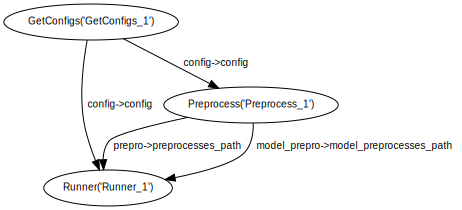

In [13]:
p

In [14]:
p.execute()

<Process(Pipeline Manager('sparse_encoding'), stopped)>

In [15]:
razor.api.libraries()

Sl. No.,Name,Technology,Install Status,Created by,Created on,Modified by,Modified on
1,rztdl_old,PYTHON,INSTALLED,Phaneendra B,"Sep 16, 2020",Himaprasoon P T,"Sep 16, 2020"
2,dotmap_latest,PYTHON,INSTALLED,Suraj Kumar,"Sep 10, 2020",Suraj Kumar,"Sep 10, 2020"
3,rukhaiya_test,PYTHON,INSTALLATION_FAILED,Abhishek Sharma,"Aug 20, 2020",Abhishek Sharma,"Aug 27, 2020"
4,SSIM_PIL,PYTHON,INSTALLED,Ayan Basak,"Jul 15, 2020",Ayan Basak,"Jul 15, 2020"
5,nltk,PYTHON,INSTALLED,Ayan Basak,"Jul 30, 2020",Ayan Basak,"Jul 30, 2020"
6,tssplit_1,PYTHON,INSTALLED,Phaneendra B,"Aug 20, 2020",Phaneendra B,"Aug 20, 2020"
7,SparseCoding,PYTHON,INSTALLED,Ayan Basak,"Jul 20, 2020",Ayan Basak,"Jul 20, 2020"
8,lightgbm,PYTHON,INSTALLED,Ayan Basak,"Aug 17, 2020",Ayan Basak,"Aug 17, 2020"
9,numpy,PYTHON,INSTALLED,amith koujalgi,"Aug 27, 2020",amith koujalgi,"Aug 27, 2020"
10,category-encoders,PYTHON,INSTALLED,vyshnav mt,"Sep 02, 2020",vyshnav mt,"Sep 02, 2020"


In [16]:
# lib1 = razor.api.libraries(name='torch').artifact()
# lib1 = razor.api.libraries(name='opencv-python').artifact()

In [17]:
get_configs.executor = rf.ContainerExecutor(cores=1, memory=1048)
preprocess.executor = rf.ContainerExecutor(cores=2, memory=5000)
runner.executor = rf.ContainerExecutor(cores=4, memory=5000)

In [18]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [19]:
deployed_pipeline

PlatformPipelineRun(project_id='f374757a-cc52-4a94-99ae-aa8e7dcea8be', pipeline_id='6d20407c-fbe1-11ea-87fc-0242ac11000b', pipeline_name='sparse_encoding', pipeline_run_id='17b291fc-481d-46c3-8905-5a66d0f9d568', pipeline_version=None, comment=None, created_on='2020-09-21T08:15:41.549+00:00', start_time=None, end_time=None, eta=0, run_at=1600676141549, run_duration=0, compute_time=0, wait_time=2, ran_by_user=RanByUser(user_name='souryadipta das', email='souryadipta.das@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='17b291fc-481d-46c3-8905-5a66d0f9d568', pipeline_name='sparse_encoding', pipeline_status='IN_PROGRESS', block_id='b01e057b-1740-45af-b21b-7877b774de88', block_run_id='564b42d1-681c-43e0-a742-5c6a06b5642f', block_name='GetConfigs_1', resource_spec=ResourceAllocated(cores=1, memory=1048, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='b01e057b-1740-45af-b21b-7877b774de88', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-09-21T08:15:42.000+00:00'), PlatformPipelineBlockRun(pipeline_run_id='17b291fc-481d-46c3-8905-5a66d0f9d568', pipeline_name='sparse_encoding', pipeline_status='IN_PROGRESS', block_id='0d7e7f44-eb18-4dc4-9690-379fa4d492ab', block_run_id='6ea576e3-5027-4dbd-a675-d3c53e1361ed', block_name='Preprocess_1', resource_spec=ResourceAllocated(cores=2, memory=5000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='0d7e7f44-eb18-4dc4-9690-379fa4d492ab', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='17b291fc-481d-46c3-8905-5a66d0f9d568', pipeline_name='sparse_encoding', pipeline_status='IN_PROGRESS', block_id='fb7ba1b2-75cc-49e6-82d3-711426e44b46', block_run_id='129748ec-7f62-482b-9ea8-cece913ba57b', block_name='Runner_1', resource_spec=ResourceAllocated(cores=4, memory=5000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='fb7ba1b2-75cc-49e6-82d3-711426e44b46', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=80, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='b01e057b-1740-45af-b21b-7877b774de88', block_run_id='564b42d1-681c-43e0-a742-5c6a06b5642f', block_name='GetConfigs_1', technology='PYTHON', log_path=None, input_parameters='{\n  "material": {\n    "dtype": "Any",\n    "required": "false",\n    "series": false,\n    "adapter": "eJxrYJmqxgABPYJFiVX5RXppOfnlern5Kak5xVN6ePLy8wviE1MSC0pSi6ZMnqIHAF/+ELQ=",\n    "validator": "eJxrYJmqwQABPYJFiVX5RXppOfnlern5Kak5xVN6+PLy8wviyxJzMlMSS/KLpkyeogcAg2wRnQ==",\n    "source_id": null,\n    "source_name": null,\n    "inferred_type": "STATIC",\n    "value": "eJxrYJnKwQABPSzpRZkpU/QAIYYEGg=="\n  }\n}', output_parameters=None, status='READY_TO_GO', created_at='2020-09-21T08:15:41.629+00:00', queued_at='2020-09-21T08:15:42.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='e18d694b-13b6-4298-bfc9-edb4616a995f', output_name='config', created_on='2020-09-21T08:15:41.685+00:00', output_status='YET_TO_START', block_transport='KAFKA')], resource_allocated=ResourceAllocated(cores=1, memory=1048, use_gp

In [23]:
eng = razor.api.engines('DS-engine')

In [25]:
eng.health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.114.95', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=12, used=0, available=12, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=55834574848.0, used=0.0, available=55834574848.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=1, used=0, available=1, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=1, available=31, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=1073741824.0, available=122406567936.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.104.139', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=2, available=14, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=2147483648.0, available=38654705664.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')])])

In [1]:
import razor

In [2]:
razor.api.engines()

S.No,Name,Description,Status,Slaves
1,DS-engine,DS Team Engine,Running,3


# Import from published

In [6]:
from razor.project.blocks.SE_Jenoptik_bundle import GetConfigs, Preprocess, Runner

In [18]:
get_configs = (
    GetConfigs()
    .material('grid')
    .config(transport=FileTransport)
    .executor(ContainerExecutor(cores=2, memory=512))
)


preprocess = (
    Preprocess()
    .config(get_configs.config)  # (series, json)
    .prepro(transport=FileTransport)
    .model_prepro(transport=FileTransport)
    .executor(ContainerExecutor(cores=2, memory=8192))
)


runner = (
    Runner()
    .model_preprocesses_path(preprocess.model_prepro)  # (series, generic)
    .preprocesses_path(preprocess.prepro)  # (series, generic)
    .config(get_configs.config)  # (series, json)
#     .mode("train")  # (series, string)
    .mode("train")
    .executor(ContainerExecutor(cores=2, memory=8192))
)



In [19]:
p = Pipeline("sparse_encoding_10", targets=[runner])  #preprocess

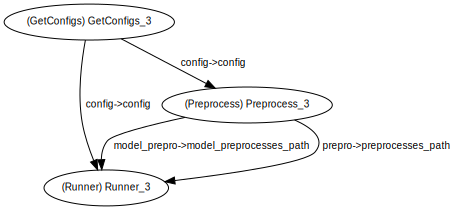

In [20]:
p.show()

In [21]:
lib1 = razor.api.libraries(name='opencv-python').artifact()
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p, libs=[lib1])


In [22]:
deployed_pipeline

PlatformPipelineRun(project_id='f374757a-cc52-4a94-99ae-aa8e7dcea8be', pipeline_id='cb51b678-d231-11ea-9d4a-abf78641ad23', pipeline_name='sparse_encoding_10', pipeline_run_id='a68ca284-643c-4615-984b-33e941647c00', pipeline_version=None, comment=None, created_on='2020-07-30T06:56:30.536+0000', start_time=None, end_time=None, eta=0, run_at=1596092190536, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='a68ca284-643c-4615-984b-33e941647c00', pipeline_name='sparse_encoding_10', pipeline_status='IN_PROGRESS', block_id='6818336e-da33-482f-a337-334ff1988577', block_run_id='a012d0d0-3eab-4be0-8edb-aeda4873d2c2', block_name='GetConfigs_3', resource_spec=ResourceAllocated(cores=2, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='6818336e-da33-482f-a337-334ff1988577', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-07-30T06:56:31.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='a68ca284-643c-4615-984b-33e941647c00', pipeline_name='sparse_encoding_10', pipeline_status='IN_PROGRESS', block_id='7bf53e53-f4fa-48d3-873a-05091f004690', block_run_id='2d280b49-753c-4e2f-a4de-630eefed4c3b', block_name='Preprocess_3', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='7bf53e53-f4fa-48d3-873a-05091f004690', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='a68ca284-643c-4615-984b-33e941647c00', pipeline_name='sparse_encoding_10', pipeline_status='IN_PROGRESS', block_id='1bf7ce91-cd74-4d37-91ec-00cd3599336e', block_run_id='c92433fa-1f0b-4afa-9afc-36491968edd4', block_name='Runner_3', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='1bf7ce91-cd74-4d37-91ec-00cd3599336e', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=63, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='6818336e-da33-482f-a337-334ff1988577', block_run_id='a012d0d0-3eab-4be0-8edb-aeda4873d2c2', block_name='GetConfigs_3', technology='PYTHON', log_path=None, input_parameters='{\n  "material": {\n    "dtype": "string",\n    "required": "false",\n    "series": false,\n    "adapter": "eJxrYJlqzAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTeoScQHxPEE8vMSWxoCS1aMrkKXoAUvYVmA==",\n    "validator": "eJxrYJnqyAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTehQcS/JzM5OdQKLBJUWZeemeIBm9ssSczJTEkvyiKZOn6AEArzAbbQ==",\n    "source_id": null,\n    "source_name": null,\n    "inferred_type": "STATIC",\n    "value": "eJxrYJnKwQABPSzpRZkpU/QAIYYEGg=="\n  }\n}', output_parameters=None, status='READY_TO_GO', created_at='2020-07-30T06:56:30.569+0000', queued_at='2020-07-30T06:56:31.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='087bf67a-4df0-4f50-9671-c837b4d957e2', output_name='config', created_on='2020-07-30T06:56:30.570+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=2, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='7bf53e53-f4fa-48d3-873a-05091f004690', block_run_id='2d280b49-753c-4e2f-a4de-630eefed4c3b', block_name='Preprocess_3', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YE